# Point Transformer:

Allen's Relations in Start time - Duration Plot as in [1]: 

![alt text](./Allen'sRelationsAndthe2DRepresentation.png "Allen's Relations in Start time - Duration Plot")


[1] Incremental Temporal Pattern Mining Using Efficient Batch-Free Stream Clustering, Thomas Seidl

In [18]:
#TODO: Move all this to package
#TODO: Extract skyline points
#TODO: left align then split: For consistency purposes, and Seasons?, Delay affecting?, 
#TODO: Get to know the skyline
#      - Get more info about activities on skyline
#      - Skyline point set prediction
#      - Skyline peaks
#      - Skyline Expectation Maximization
#      - Shadow of skyline 

#TODO: Pseudonimize data for uni
#TODO: Drifts?
#TODO: Not left_align

# Cleaning to write?: Erwähnen in Bezug auf dass es necessary war 


## Experiments:

Experiment logs conain variations of: 
- Time
- Structure
- Allen relationships between activities

<style> table {display: block} </style>
    
    
| # Traces | # Unique activities | Filename | Time variation | Structure variation | Allen variation  | Further description | Expectations | Observations | Further ideas |
|----------|---------------------|:---------|:---------------|---------------------|------------------|---------------------|:-------------|--------------|---------------|
|       1  |          7          | catts_1trace_7act_0dur_running-example.csv | Constant 0 sec duration | None | "after/before" relations only  || Points are equidistant.<br> S-E plot: Trace is straight over the diagonal and only 2 allen lines can be seen for any activity.<br> S-D plot: Trace horizontal at 0 and only one allen line is visible. |Consistency verified for activities||
|       1  |          7          | catts_1trace_7act_12hDur_running-example.csv | Constant 12h duration | None | "after/before" relations only  || Points are equidistant. <br> S-E plot: Trace is straight with a constant distance from diagonal. <br> S-D plot: Trace is horizontal.| Allen lines confirm "after", "before" relations bt. events. | Further investigate average plot |
|       1  |          7          | catts_1trace_7act_1dayDur_meets_running-example.csv | Constant 1d duration | None | Contains "meets" relations || 'reinitiate request' is met by 'decide' and meets 'examine thoroughly'| Allen lines in both plots are consistent with 'meets' relation ||
|       1  |          7          | catts_1trace_7act_meetsStartedByFinishedBy_running-example.csv | Constant duration | None | Contains "started by", "meets" & "finished by" relations || 'reinitiate request' is met by 'check ticket', finished by 'decide', started by 'examine thoroughly' and meets a second 'check ticket' | Allen lines in both plots are consistent with 'meets', 'started by', and 'finished by' relations | |
|       1  |          7          | catts_1trace_7act_meetsStartsFinishes_running-example.csv | Constant duration | None | Contains "starts", "meets" & "finishes" relations || 'reinitiate request' is met by 'check ticket', starts 'decide', finishes 'examine thoroughly' and meets a second 'check ticket' | Allen lines in both plots are consistent with 'meets', 'starts', and 'finishes' relations ||
|       1  |          7          | catts_1trace_7act_meetsOverlapsOverlappedBy_running-example.csv | Constant duration | None | Contains "overlaps", "meets" & "overlapped by" relations || 'reinitiate request' is met by 'check ticket', overlaps 'decide', is overlapped by 'examine thoroughly' and meets a second 'check ticket' | Allen lines in both plots are consistent with 'meets', 'overlaps', and 'overlapped by' relations || 
|       1  |          7          | catts_1trace_7act_varDur_running-example.csv | Variable duration bt. activities | None | "after/before" relations only || S-E plot: Is not a straight line. S-D plot: Is not a straight line. |Instead of diagonal draw trace horizontal?|         
|       2  |          7          | catts_2traces_7act_12h1actDevEndTime_running-example.csv | Constant deviation bt. traces for one activity | None | "after/before" relations only | Expectation and reality traces | One trace is a as in 0 duration plots, the other deviates only on one point forming a peak in the trace line. | Peaks can be used to identify outliers regarding time deviations from expectations. ||
|       2  |          7          | catts_2traces_7act_12hconstDevEndTime_running-example.csv | Constant deviation bt. traces for all activities | None | "after/before" relations only | Expectation and reality traces | Traces are both straight equidistant lines. | Distances from expectations can be used to identify outliers and drifts/shifts? ||
|       2  |          7          | catts_2traces_7act_varDevEndTime_running-example.csv | Variable deviation on 'end_time' bt. traces for every activity | None | "after/before" relations only | Expectation and reality traces | One trace deviates only on 'end_time' from the other and is not a straight line. | Time outliers can be identified by y distance to corresponding expectation activity point. <br> | Investigate both 'timestamps' deviations |
|       2  |          7          | catts_2traces_7act_varDevStartTime_noShift_running-example.csv | Variable deviation on 'start_time' bt. traces for every activity but first one. | None | "after/before" relations only | Expectation and reality traces | One trace deviates only on 'start_time' from the other and is not a straight line. <br> S-E plot: Points horizontally of each other <br> S-D plot: No straight line. | S-D plot:  Deviating activities show in the same 'finish' allen line.  | Per activity normalization? Drawing lines between corresponding activity points? |  
|       2  |          7          | catts_2traces_7act_varDevStartTime_running-example.csv | Variable deviation on 'start_time' bt. traces for every activity | None | "after/before" relations only | Expectation and reality traces | One trace deviates only on 'start_time' from the other and is not a straight line. <br> S-E plot: Points horizontally of each other <br> S-D plot: No straight line. | Time outliers can be identified by y distance to corresponding expectation activity point. <br> S-E plot: If first timestamp is not same in both traces, rest of timestamps are shifted. If activity's normalized 'start_time' is the same between traces, it will show in same vertical. <br> S-D plot: Activities without varation are on same horizontal, since duration stayed the same. If activity's normalized 'start_time' is the same between traces, it will show in same vertical. Other wise the rest of the trace is shifted by the first activity's 'start_time' deviation | Add plot option: plot normalization to only one trace instead of every trace. |
|       2  |          7          | catts_2traces_7act_varDevBothTimes_12hDur_noShift_running-example.csv | Variable deviation on 'start_time' and 'end_time', constant 12h duration bt. traces for every activity but first one. | None | "after/before" relations only | Expectation and reality traces | One trace deviates on 'start_time' and 'end_time' from the other and is a straight line overlapp, given constant duration bt. traces. <br> S-E plot: Parallel to diagonal. <br> S-D plot: Horizontal at 12h duration | S-D plot:   ||
|       2  |          7          | catts_2traces_7act_varDevBothTimes_12hDur_running-example.csv | Variable deviation on 'start_time' and 'end_time', constant 12h duration bt. traces for every activity. | None | "after/before" relations only | Expectation and reality traces ||||
|       2  |          7          | catts_2traces_7act_varDevBothTimes_6hDurDev_noShift_running-example.csv | Variable deviation on 'start_time' and 'end_time' (all act's but first), constant 6h duration deviation bt. traces for every activity. | None | "after/before" relations only | Expectation and reality traces | One trace deviates on 'start_time', 'end_time' and duration from the other and is a parallel. <br> S-E plot: Parallel to diagonal. <br> S-D plot: Parallel horizontal | S-D plot:   ||
|       2  |          7          | catts_2traces_7act_varDevBothTimes_6hDurDev_running-example.csv | Variable deviation on 'start_time' and 'end_time', constant 6h duration deviation bt. traces for every activity. | None | "after/before" relations only | Expectation and reality traces ||||
|       2  |          7          | catts_2traces_7act_varDevBothTimes_varDurDev_noShift_running-example.csv | Variable deviation on 'start_time' and 'end_time', variable duration deviation bt. traces for every activity but first one. | None | "after/before" relations only | first 'check ticket' conforms on 'start_time'; <br> 'reinitiate request' conforms on duration; <br> second 'decide' conforms on 'end_time'; <br>'pay compensation' conforms on both timestamps | Trace '3' is a bent line since it irregularly deviates from the trace '0', which straight line.  <br> S-E plot: Conformant activities share allen lines horizontals, verticals or diagonal. | S-E plot: first 'check ticket' points share vertical; <br> 'reinitiate request' points share diagonal; <br> second 'decide' points share vertical; <br>'pay compensation' points are equal. | Through Allen lines conformity between traces is visible.
|       2  |          7          | catts_2traces_7act_varDevBothTimes_varDurDev_running-example.csv | Variable deviation on 'start_time' and 'end_time', variable duration deviation bt. traces for every activity. | None | "after/before" relations only | first 'check ticket' conforms on 'start_time'; <br> 'reinitiate request' conforms on duration; <br> second 'decide' conforms on 'end_time'; <br>'pay compensation' conforms on both timestamps  | Trace '3' is a bent line since it irregularly deviates from the trace '0', which straight line. Through shift 'start_time' deviations will not be visible. <br> S-E plot: Conformant activities in 'end_time' and duration share allen lines horizontals, verticals or diagonal.| S-E plot: Through shift lack of deviation on first 'check ticket' is not visible; <br> 'reinitiate request' and 'pay compensation' share diagonal; <br> share vertical; <br>'pay compensation' does not deviate on both timestamps Through shift conformity on first 'check ticket' is not visible.| Through first activity shift conformity of start_times after first activity is not visible.; <br> | 
|       2  |          7          |  | Constant deviation bt. traces for all activities | 2 activities swapped | "after/before" relations only | Expectation and reality traces ||| Erkennt man outlier (structure/allen struktur/time)? |
|      10  |          8          |  | Variable deviation bt. traces for every activities | None | "after/before" relations only | Expectation and reality traces |||
|      10  |          8          |  | Variable deviation bt. traces for every activities | multiple activities swapped | "after/before" relations only | Expectation and reality traces |||
|      10  |          8          |  | Variable deviation bt. traces for every activities | multiple activities swapped | variations of relations | Expectation and reality traces |||
|     100  |          8          |  | Variable deviation bt. traces for every activities | None | "after/before" relations only | Expectation and reality traces |||
|     100  |          8          |  | Variable deviation bt. traces for every activities | multiple activities swapped | "after/before" relations only | Expectation and reality traces |||
|     100  |          8          |  | Variable deviation bt. traces for every activities | multiple activities swapped | variations of relations | Expectation and reality traces |||
...


## Excecution: 

In [19]:
import os
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.lines as mlines
import numpy as np
import sys
import random

In [20]:
csv_list = []
appended = pd.DataFrame()
#LUIGI_LOG_PATH='/usr/local/trustyou/home/andream/nfs/processmining/experiments'
LUIGI_LOG_PATH = '/usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily/'
#LUIGI_LOG_PATH = '/usr/local/trustyou/home/andream/nfs/processmining/minilogs/table-precomp/logs/tch/'
for filename in os.listdir(LUIGI_LOG_PATH):
    #if filename.endswith('.csv') and filename.startswith('catts_2traces_7act_varDevBothTimes_varDurDev_running-example.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_v'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_0dur_running-example.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_1dayDur_meets_running-example.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_meetsStarts'):
    if filename.endswith('.csv') and filename.startswith('p'):
        log_path = LUIGI_LOG_PATH+'/'+filename
        csv_list.append(filename)
        print('Preprocessing... ',log_path)
        df = pd.read_csv(log_path, index_col=False)
        appended = appended.append(df)

#appended_df
csv_list.sort()
print(csv_list)

filename = os.path.splitext(csv_list[0])[0]

#appended_df.to_datetime(start_time, format="%Y-%m-%d:%H:%M:%S").sort_values()
appended['start_time'] = pd.to_datetime(appended['start_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
appended['end_time'] = pd.to_datetime(appended['end_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
appended = appended.sort_values(by=['start_time'], ascending=True)
appended['case'] = appended.apply(lambda row: str(row['case']), axis=1)
print(len(appended))
appended.head()

Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily//param_catts_daily.2019-09-.csv
['param_catts_daily.2019-09-.csv']
15711


,case,activity,start_time,end_time
14463,daily.2019-09-01_09-29-01.csv,AllTasks,2019-09-01 09:29:23,2019-09-03 03:43:13
14468,daily.2019-09-01_09-29-01.csv,CrawlFeedTask,2019-09-01 09:42:15,2019-09-01 10:01:16
14467,daily.2019-09-01_09-29-01.csv,ProxySetupTask,2019-09-01 09:42:15,2019-09-01 09:54:13
14464,daily.2019-09-01_09-29-01.csv,DumpTask(target_filename=None)(chunk=prep)(sql_filename=daily_urls),2019-09-01 09:42:15,2019-09-01 09:43:44
14465,daily.2019-09-01_09-29-01.csv,DumpTask(target_filename=None)(chunk=prep)(sql_filename=regular_urls),2019-09-01 09:42:15,2019-09-01 10:09:02


In [21]:
EXCLUDED_TASKS=['AllTasks']

counts = appended.groupby(['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
counts = counts.sort_values(by=['counts'], ascending = False)
counts.head()

#appended = appended.head(100)
#print(len(appended))
unique_act = appended['activity'].unique().tolist()
print(len(unique_act), ' activities')
#print(unique_act)

short_activities=[]
for item in unique_act:
    short_name = item.split('(',1)[0]
    short_activities.append(short_name)
unique_short_activities = list(sorted(set(short_activities)-set(EXCLUDED_TASKS)))
print(len(unique_short_activities),' short activity names:')
print(unique_short_activities,'\n')

unique_trace = appended['case'].unique().tolist()
print(len(unique_trace), ' cases')
#print(unique_trace)

254  activities
66  short activity names:
['AlertsTask', 'ChunkReviewTimelineTask', 'ChunkTask', 'CleanupStarwoodDataTask', 'ClusterScoreTask', 'ConsolidatedAlertsTask', 'ConvertDedupTask', 'ConvertDumpTask', 'ConvertDumpXmlifyTask', 'ConvertFeedTask', 'CrawlChunkTask', 'CrawlFeedTask', 'CrawlPrivateDataTask', 'CrawlTask', 'DBDumpTask', 'DetectLanguageTask', 'DumpTask', 'ExtractChunkTask', 'ExtractTask', 'FetchInputTask', 'FilterOutResponsesTask', 'GeneratePIITask', 'GroupPreDumpTask', 'GroupTask', 'HAProxySetupTask', 'HAProxyTeardownTask', 'MergeNewData', 'NewPrivateDataTask', 'NewPublicDataTask', 'PartitionConvertDumpTask', 'PartitionConvertDumpXmlifyTask', 'PartitionCrawlInputTask', 'PrepTask', 'PrevChunkNewReviewsOriginChangeTask', 'ProxySetupTask', 'ProxyTeardownTask', 'QCCountTask', 'QCUpdateCrawlDateTask', 'QCUpdateTask', 'QCValidateExtractTask', 'QCValidateExtractXmlifyTask', 'QCValidateJsonifyTask', 'QCValidateTask', 'QualityCheckTask', 'ReportTask', 'ResolveFeedIDsTask', 'Res

In [22]:
def get_color_from_label(label, color):
    return color
    
def multiline_text(text, max_in_line):
    many_lines = []
    result=''
    i=0
    while len(text)>max_in_line and i==0: 
        many_lines.append(text[0:max_in_line+1])
        text = text[max_in_line+1:]
    if len(text): 
        many_lines.append(text)
    for item in many_lines:
        result += item + '\n'
    return result

def title_from_list(act_selection):
    result=''
    for act in act_selection:
        result+=act+'_'
    return result
    
def plot_newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color='grey', linestyle='--', linewidth=1)
    ax.add_line(l)
    return l

def draw_traces(data_selection, ax, draw_skylines=None):
    colormapt = cm.gist_ncar
    trace_colorlist = [colors.rgb2hex(colormapt(i)) for i in np.linspace(0, 0.9, len(unique_trace))]
    trace_legend = dict(zip(unique_trace, trace_colorlist))
    for j, k in enumerate(data_selection['case'].drop_duplicates()):
        current = data_selection[data_selection['case']==k]
        l = k
        c = trace_legend.get(l)

        if draw_skylines:
            skyline = get_skyline_points(current)
            ax.plot(skyline['num_start'], skyline['num_end'], label='skyline '+k, zorder=0, color=c)
        else: 
            ax.plot(current['num_start'], current['num_end'], label='trace '+k, zorder=0, color=c)
            
def draw_allen_lines(allen_point, ax, yax, duration_plot=None):
            x = allen_point['num_start'].values[0]
            y = allen_point['num_end'].values[0]

            if duration_plot: 
                ax.axvline(x, c='grey', linewidth=1, linestyle='--')
                ax.axvline(x+y, c='grey', linewidth=1, linestyle='--')
                plot_newline([x,y],[x+2*y,-y])
                plot_newline([x-y,y],[x+y,-y])
            else:
                ax.plot([x,x],[x,yax],'k-', c='grey', linewidth=1, linestyle='--')
                ax.plot([y,y],[y,yax],'k-', c='grey', linewidth=1, linestyle='--')
                ax.plot([0,x],[x,x],'k-', c='grey', linewidth=1, linestyle='--')
                ax.plot([0,y],[y,y],'k-', c='grey', linewidth=1, linestyle='--')
                

In [23]:
def plot_point_transformer(title, data_selection, activity=None, traces=None,  allen_point=None, size=None, duration_plot=None, draw_skylines=None, output_path=None):
    fig, ax = plt.subplots()
    
    if size: 
        fig.set_size_inches(18.5, 18.5)

    #colormap = cm.nipy_spectral
    #colormap = cm.prism
    #colormap = cm.tab20
    colormap = cm.hsv
    #colormap = cm.gist_rainbow
    #colormap = cm.gist_ncar
    
    unique_act = sorted(data_selection['activity'].unique().tolist())
    unique_trace = data_selection['case'].unique().tolist()
    
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(unique_act))]
    legend = dict(zip(unique_act, colorlist))
    colorby = 'activity'
    
    if activity:
        data_selection = data_selection.loc[data_selection['activity']==activity].reset_index()
        colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(unique_trace))]
        legend = dict(zip(unique_trace, colorlist))
        colorby = 'case'
    elif traces:
        data_selection = data_selection.loc[data_selection['case'].isin(traces)].reset_index()
    
    for i, e in enumerate(data_selection['num_start']):
        x = data_selection['num_start'][i]
        y = data_selection['num_end'][i]
        l = data_selection[colorby][i]
        c = legend.get(l)

        ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)
    
    yin, yax= ax.get_ylim()
    xin, xax= ax.get_xlim()
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    
    if not duration_plot: 
        #Draw diagonal
        plot_newline([0,0],[max(xax,yax),max(xax,yax)])
        ax.set_ylabel('End time [mins]')
    else: 
        ax.set_ylabel('Duration [seconds]')

    if traces:
        draw_traces(data_selection, ax, draw_skylines=draw_skylines)
            
    if not allen_point is None :# Weird if statement because of maybe empty object or dataframe
        draw_allen_lines(allen_point, ax, yax, duration_plot=duration_plot)    
    
    ax.legend()
    
    ax.set_xlabel('Start time [mins]')

    xlocs, labels = plt.xticks()
    ylocs, labels = plt.yticks()
    plt.xticks(xlocs[1:], get_time_list_from_seconds(xlocs[1:]),rotation='vertical')
    plt.yticks(ylocs[1:], get_time_list_from_seconds(ylocs[1:])) 

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(multiline_text(title, 175))
    
    if output_path: 
        print('Saving in ',output_path)
        fig.savefig(output_path,  bbox_inches='tight')
        
    #plt.show()
    plt.close(fig)
    return fig
#plot_point_transformer('Point transformer: Activity \''+ str(snippet['activity'][6]) + '\' only', snippet , activity='reject request')
#plot_point_transformer('Point transformer: All activities in all traces', snippet)
#plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet)
#plot_point_transformer('Point transformer: Average trace from all activities', snippet)


In [24]:
def get_zero_points(group):
    group['zero_point'] = group['start_time'].min()
    return group

def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

def get_time_list_from_seconds(list):
    result = []
    for item in list:
        if item < 0: 
            result.append('')
        else: 
            result.append(datetime.timedelta(seconds=item))
    return result

def avg_datetime(series):
    averages = (series.sum())/len(series)
    #averages = time.strftime('%H:%M:%S', time.gmtime(averages))
    return averages

def get_average_times(group):
    group['average_start'] = time.strftime('%H:%M:%S', time.gmtime(avg_datetime(group['num_start'])))
    group['average_end'] = time.strftime('%H:%M:%S', time.gmtime(avg_datetime(group['num_end'])))
    group['num_start'] = avg_datetime(group['num_start'])
    group['num_end'] = avg_datetime(group['num_end'])
    return group

def get_data_selection_avgtrace(df):
    average_trace = df[['case','activity','rel_start','rel_end','num_start','num_end']].iloc[: , :]
    average_trace = average_trace.groupby(['activity'])
    average_trace = average_trace.apply(get_average_times)
    average_trace = average_trace.drop_duplicates('activity', keep='first').reset_index()
    average_trace['case'] = 'Average Case'
    average_trace = average_trace[['activity','average_start', 'average_end','num_start','num_end', 'case']].sort_values(by=['num_start'])
    return average_trace

def get_skyline_points(df):
    #skyline = pd.DataFrame(columns=['x','y'])
    df.sort_values(by=['num_start'])
    max_x = []
    max_y = []
    for i, e in enumerate(df['num_start']):
        maxi = max(df['num_start'][0:i+1].values.tolist())
        mayi = max(df['num_end'][0:i+1].values.tolist())
        if maxi in df[df['num_end']==mayi]['num_start'].values:
            max_x.append(maxi)
            max_y.append(mayi)

    skyline = pd.DataFrame({'num_start':max_x, 'num_end':max_y})
    skyline = skyline.drop_duplicates().reset_index()[['num_start','num_end']]

    return skyline

#first_case = snippet.loc[snippet['case']==snippet['case'][0]].reset_index()
#get_skyline_points(first_case).head()

def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])



def get_relative_timestamps(df):
    relatived = df.copy()
    #print('First timestamp in dataframe ', df['start_time'].min())
    #print('Last timestamp in dataframe ',df['end_time'].max())
    grouped = df.groupby(['case'])
    grouped = grouped.apply(get_zero_points)
    #print('Grouped:', len(grouped), 'columns', grouped.columns.tolist())

    
    relatived = pd.merge(grouped, relatived, on = ['case', 'activity', 'start_time', 'end_time'], how = 'inner') 
    #print('Merged relatived:', len(relatived), 'columns', relatived.columns.tolist())
    
    excluding = EXCLUDED_TASKS
    relatived['rel_start'] = relatived.apply(lambda row: 
                                           str(get_duration(str(row['zero_point']),
                                                            str(row['start_time']))), axis=1)
    relatived['rel_end'] = relatived.apply(lambda row: 
                                           str(get_duration(str(row['zero_point']),
                                                            str(row['end_time']))), axis=1)
    
    relatived['num_start']= list(pd.to_timedelta(relatived['rel_start'], errors="coerce").dt.total_seconds ())
    relatived['num_end']= list(pd.to_timedelta(relatived['rel_end'], errors="coerce").dt.total_seconds ())

    #relatived = relatived[['case', 'activity','rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time']]

    relatived = relatived.sort_values(by=['num_start'], ascending=True)
    relatived = relatived[~relatived['activity'].isin(excluding)].reset_index()
    #print('Exclusive: ', len(relatived), 'columns', relatived.columns.tolist())

    
    relatived = relatived[['case','activity','rel_start','rel_end','num_start','num_end','start_time','end_time']].iloc[: , :]
    #relatived = relatived.iloc[199:500 , :].reset_index()
    relatived = relatived.sort_values(by=['case','num_start'], ascending=True)
    #print('Relatived: ', len(relatived), 'columns', relatived.columns.tolist())
    return relatived

def plot_selected_traces(snippet, output_path=None):
    #plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet)
    traces_selection = snippet['case'].drop_duplicates().tolist()[0:3]
    #traces_selection = [unique_trace[1]]
    data_selection = snippet.loc[snippet['case'].isin(traces_selection)].reset_index().iloc[:]
    if len(data_selection[data_selection['num_start']>0])>0:
        point = data_selection[data_selection['num_start']>0].sample(n=1)
        #point = data_selection.iloc[ 1 , : ].to_frame().transpose()
        figurept = plot_point_transformer('Point transformer: Trace '+ str(traces_selection) + ' only, Allen\'s point: '+str(point['activity'].values)+' in '+str(point['case'].values),
                                          data_selection, size=1, traces=traces_selection, allen_point=point, output_path=output_path)
    else: 
        figurept = plot_point_transformer('Point transformer: Trace '+ str(traces_selection) + ' only.',
                                          data_selection, size=1, traces=traces_selection, output_path=output_path)
    #print(data_selection[['activity','rel_start','rel_end']])
    
def plot_all_traces(snippet, output_path=None, draw_skylines=None):
    traces_selection = snippet['case'].drop_duplicates().tolist()
    #print(point)
    if len(snippet[snippet['num_start']>0])>0:
        point = snippet[snippet['num_start']>0].sample(n=1)
        #point = snippet.iloc[ 1 , : ].to_frame().transpose()
        figurept = plot_point_transformer('Point transformer: All activities in all traces. Allen\'s point: '+str(point['activity'].values)+' in '+str(point['case'].values), snippet, allen_point=point, traces=traces_selection,  size=1 , draw_skylines=draw_skylines, output_path=output_path)
        #plot_point_transformer('Point transformer: All activities in all traces', snippet, size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])
    else:
        figurept = plot_point_transformer('Point transformer: All activities in all traces.', snippet, traces=traces_selection,  size=1 , draw_skylines=1, output_path=output_path)
        
    
def plot_average_trace(snippet, output_path = None, draw_skylines=None):
    #FIXME: Average End and start are only taking hours:minutes and not days into account
    #print(snippet['activity'].drop_duplicates().tolist())
    data_selection = get_data_selection_avgtrace(snippet).iloc[:]
    traces_selection = data_selection['case'].drop_duplicates().tolist()
    if len(data_selection[data_selection['num_start']>0])>0:
        point = data_selection[data_selection['num_start']>0].sample(n=1)
        #data_selection.iloc[ 1 , : ].to_frame().transpose()
        #print(data_selection)
        figurept = plot_point_transformer('Point transformer: Average trace from all activities, Allen\'s point: '+str(point['activity'].values)+' in '+str(point['case'].values), 
                                          data_selection, traces=traces_selection, size=1, allen_point=point, output_path=output_path, draw_skylines=draw_skylines)
        #plot_point_transformer('Point transformer: Average trace from all activities', snippet, allen_point=point)
    else:
        figurept = plot_point_transformer('Point transformer: Average trace from all activities', 
                                          data_selection, traces=traces_selection, size=1, output_path=output_path, draw_skylines=draw_skylines)

def plot_selected_activities(snippet, output_path = None):
    #TODO: Adapt frame dynamically
    #TODO: Add start by zero option
    unique_act = snippet['activity'].unique().tolist()
    #print('There are ', len(unique_act), 'unique activities.')
    activity_selection=unique_act[0]
    #print(activity_selection)
    figurept = plot_point_transformer('Point transformer: Activity \''+ str(activity_selection) + '\' only', snippet , activity=activity_selection, size=1, output_path=output_path)
    #print(snippet[snippet['activity']==activity_selection])
    
def plot_duration_selectedtraces(w_duration, output_path=None):
    #TODO: Suspect 'meets' line is wrong
    traces_selection = w_duration['case'].drop_duplicates().tolist()[0:3]
    if len(w_duration[w_duration['num_start']>0])>0:
        point = w_duration[w_duration['num_start']>0].sample(n=1)
        #point = w_duration.iloc[ 2 , : ].to_frame().transpose()
        #print(point)
        figurept = plot_point_transformer('Point transformer: Trace '+ str(traces_selection) + ' only, Allen\'s point: '+str(point['activity'].values)+' in '+str(point['case'].values),
                                          w_duration, duration_plot=1, allen_point=point, traces=traces_selection, size=1, output_path=output_path)
        #plot_point_transformer('Point transformer: All activities in all traces', snippet, size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])
    else:
         figurept = plot_point_transformer('Point transformer: Trace '+ str(traces_selection),
                                          w_duration, duration_plot=1, traces=traces_selection, size=1, output_path=output_path)   

#TODO: Draw skylines
def plot_duration_alltraces(w_duration, output_path=None): 
    traces_selection= w_duration['case'].drop_duplicates().tolist()
    if len(w_duration[w_duration['num_start']>0])>0:
        point = w_duration[w_duration['num_start']>0].sample(n=1)
        #point = w_duration.iloc[ 5 , : ].to_frame().transpose()
        #print(appended[['case','activity','start_time','end_time']].sort_values(by=['case']))
        figurept = plot_point_transformer('Point transformer: All activities in all traces', w_duration, size=1, duration_plot=1, allen_point=point, traces=traces_selection, output_path=output_path)
        #plot_point_transformer('Point transformer: All activities in all traces', snippet, size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])
    else: 
        figurept = plot_point_transformer('Point transformer: All activities in all traces', w_duration, size=1, duration_plot=1, traces=traces_selection, output_path=output_path)
        

In [25]:
def plot_point_transformer_selection(subset, output_path_prefix):
    activity = subset['activity'].apply(lambda row: row.split('(',1)[0]).unique().tolist()
    #filename_addition = title_from_list(activity)
    filename_addition = ''
    output_path_prefix += '_'+filename_addition
    print('\nSubset of ', activity, 'has:')
    print(len(subset), ' entries')
    
    unique_act = subset['activity'].unique().tolist()
    print(len(unique_act), 'different activities')
    #print(unique_act['activity'].tolist(),'\n')
    
    unique_trace = subset['case'].unique().tolist()
    print(len(unique_trace), ' cases')
    #print(unique_trace, '\n')
    
    snippet = get_relative_timestamps(subset)
    
    outputpath_seltr = output_path_prefix+'point_transformer_selectedTraces'+'.png'
    #print(outputpath_seltr)
    #plot_selected_traces(snippet, output_path=outputpath_seltr)
    
    output_path_atr = output_path_prefix+'point_transformer_allTraces'+'.png'
    #print(output_path_atr)
   # plot_all_traces(snippet, output_path=output_path_atr)
    
    output_path_atr = output_path_prefix+'point_transformer_allTraces_skyline'+'.png'
    #print(output_path_atr)
    #plot_all_traces(snippet, output_path=output_path_atr, draw_skylines=1)
    
    output_path_avtr = output_path_prefix+'point_transformer_averageTrace'+'.png'
    #print(output_path_avtr)
    #plot_average_trace(snippet, output_path=output_path_avtr)
    
    output_path_avtr = output_path_prefix+'point_transformer_averageTrace_skyline'+'.png'
    #print(output_path_avtr)
    plot_average_trace(snippet, output_path=output_path_avtr, draw_skylines=1)
    
    output_path_sa = output_path_prefix+'point_transformer_selectedAct'+'.png'
    #print(output_path_sa)
    #plot_selected_activities(snippet, output_path=output_path_sa)
    
    w_duration = snippet.copy()
    w_duration['duration'] = w_duration.apply(lambda row: str(get_duration(str(row['start_time']),str(row['end_time']))), axis=1)
    w_duration['rel_end']=w_duration['duration']
    w_duration['t_duration']= w_duration.apply(lambda row: (get_duration(str(row['start_time']),str(row['end_time'])).total_seconds()), axis=1)
    w_duration['num_end']=w_duration['t_duration']
    w_duration = w_duration[['case','activity','rel_start','num_start', 'rel_end', 'num_end']]

    #print(w_duration.columns)
    #print(len(w_duration))
    
    output_path_st_duration = output_path_prefix+'point_transformer_duration_selectedTraces'+'.png'
    #print(output_path_st_duration)
    #plot_duration_selectedtraces(w_duration, output_path=output_path_st_duration)
    
    output_path_duration = output_path_prefix+'point_transformer_duration_allTraces'+'.png'
    #print(output_path_duration)
    #plot_duration_alltraces(w_duration, output_path=output_path_duration)

    return snippet

In [26]:
pd.set_option('display.max_colwidth', -1)

#index_used=[[0,31],[21,51],[41,71],[61,91],[81,111],[87,117],
#            [101,119],[117,120],[118,122],[120,126],[123,156],
#            [139,170],[141,171],[170,178],[175,216],[206,246],[216,256]]

for indexes in index_used:
    #subset = appended[appended['activity'].str.startswith('ExtractTask') & appended['case']]
    subset = appended[appended['activity'].isin(average_trace_activities[indexes[0]:indexes[1]])]
    #subset = appended[appended['activity'].isin(average_trace_activities[indexes[0]:indexes[1]]) & ~appended['activity'].str.startswith('ExtractTask(crawler=creepy-crawly)(chunk')]

    output_prefix = LUIGI_LOG_PATH+'graphs/avgActSlideSplit/'+filename+'All_'+str(indexes[0])+'_'+str(indexes[1])+'act_'+str(len(subset))+'pts'
    #print(output_prefix)

    print(len(subset),' length of subset')
    
    #print(average_trace_activities[indexes[0]:indexes[1]])
    #subset.head()
    #subset= appended.copy()
    #subset = appended[appended['case']=='daily.2019-09-01_09-29-01.csv']
    #snippet = plot_point_transformer_selection(subset, output_prefix)
    #snippet.head()

NameError: name 'index_used' is not defined

In [27]:
def get_skyline_points(df):
    #skyline = pd.DataFrame(columns=['x','y'])
    df.sort_values(by=['num_start'])
    max_x = []
    max_y = []
    activity = []
    case = []
    for i, e in enumerate(df['num_start']):
        maxi = max(df['num_start'][0:i+1].values.tolist())
        mayi = max(df['num_end'][0:i+1].values.tolist())
        if maxi in df[df['num_end']==mayi]['num_start'].values:
            max_x.append(maxi)
            max_y.append(mayi)
            activity.append(df['activity'][i])
            case.append(df['case'][i])

    skyline = pd.DataFrame({'num_start':max_x, 'num_end':max_y, 'activity': activity, 'case': case})
    skyline = skyline.drop_duplicates().reset_index()[['num_start','num_end','activity','case']]

    return skyline

subset = appended.copy()
#subset = appended[appended['activity'].str.startswith('CrawlTask')].head(1000)
#print(subset['activity'][0])
print(len(subset),' length of subset')
output_prefix = LUIGI_LOG_PATH+'graphs/'+filename
print(output_prefix)
#snippet = plot_point_transformer_selection(subset, output_prefix)
subset = get_relative_timestamps(subset)
skyline_points = get_skyline_points(subset)
skyline_points.head()

15711  length of subset
/usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily/graphs/param_catts_daily.2019-09-


,num_start,num_end,activity,case
0,772.0,1913.0,DumpTask(target_filename=None)(chunk=prep)(sql_filename=reprocess_urls),daily.2019-09-16_19-44-01.csv
1,772.0,1913.0,DumpTask(target_filename=None)(chunk=prep)(sql_filename=daily_urls),daily.2019-09-16_19-44-01.csv
2,772.0,1913.0,DumpTask(target_filename=None)(chunk=prep)(sql_filename=regular_urls),daily.2019-09-16_19-44-01.csv
3,772.0,2379.0,ProxySetupTask,daily.2019-09-16_19-44-01.csv
4,772.0,2379.0,CrawlFeedTask,daily.2019-09-16_19-44-01.csv


In [89]:
print(len(skyline_points), 'points are part of skylines')
unique_sk_activities = skyline_points['activity'].unique().tolist()
print(len(unique_sk_activities), 'activities in the skyline')
skyline_points.groupby('case').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

activities=[]
for i, case in enumerate(skyline_points['case'].unique()):
    acts = skyline_points[skyline_points['case']==case]['activity'].unique().tolist()
    activities.append(acts)
    print(case, len(acts))

representative = skyline_points[['case','activity']].drop_duplicates()
rep_appereances = representative.groupby(by = ['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
#rep_appereances = skyline_points.groupby(by = ['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

pd.set_option('display.max_rows', None)
print('\n',len(rep_appereances), 'Activities appear in the skyline:')
rep_appereances
#rep_appereances[rep_appereances['counts']<13]

#rep_appereances.groupby(by = ['counts']).size().reset_index(name='activities').sort_values(by=['counts'], ascending=False)

2824 points are part of skylines
244 activities in the skyline
daily.2019-09-16_19-44-01.csv 207
daily.2019-09-04_23-23-01.csv 212
daily.2019-09-18_14-08-01.csv 203
daily.2019-09-15_01-41-01.csv 203
daily.2019-09-11_05-40-02.csv 207
daily.2019-09-03_03-44-01.csv 207
daily.2019-09-01_09-29-01.csv 212
daily.2019-09-20_12-49-01.csv 238
daily.2019-09-22_07-40-01.csv 220
daily.2019-09-06_20-34-01.csv 215
daily.2019-09-13_04-11-01.csv 200
daily.2019-09-09_01-34-02.csv 204
daily.2019-09-24_05-05-02.csv 112

 244 Activities appear in the skyline:


,activity,counts
122,ExtractChunkTask(crawler=creepy-crawly)(chunk=01),13
186,QCValidateTask(what=review)(chunk=01),13
108,DumpTask(target_filename=review_2016_1)(chunk=prep)(sql_filename=review),13
71,CrawlTask(crawler=creepy-crawly)(chunk=03),13
109,DumpTask(target_filename=review_2016_2)(chunk=prep)(sql_filename=review),13
69,CrawlTask(crawler=creepy-crawly)(chunk=01),13
183,QCValidateJsonifyTask(chunk=01),13
180,QCValidateExtractXmlifyTask(chunk=01),13
177,QCValidateExtractTask(chunk=01),13
59,CrawlChunkTask(crawler=creepy-crawly)(chunk=01),13


/usr/local/trustyou/home/andream/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Number of activities')

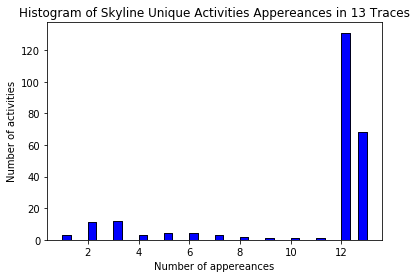

In [81]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(rep_appereances['counts'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(rep_appereances['counts'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Skyline Unique Activities Appereances in 13 Traces')
plt.xlabel('Number of appereances')
plt.ylabel('Number of activities')

ValueError: color kwarg must have one color per dataset

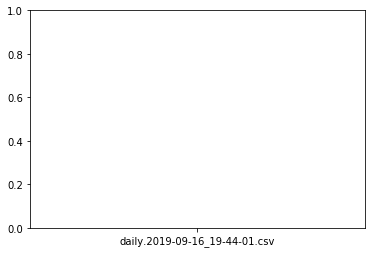

In [86]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(skyline_points['activity'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(skyline_points['activity'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Skyline Unique Activities Appereances in 13 Traces')
plt.xlabel('Number of appereances')
plt.ylabel('Number of activities')

In [27]:
appended[appended['activity'].str.startswith('CrawlTask')]

,case,activity,start_time,end_time
14495,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=ty-superman)(chunk=01),2019-09-01 11:05:36,2019-09-01 11:06:34
14496,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=ty-superman)(chunk=03),2019-09-01 11:05:36,2019-09-01 11:06:41
14516,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:55:14
14515,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:08:16
14513,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:58:09
14512,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:37:07
14514,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:57:05
14510,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:13:06
14509,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:22:29
14508,daily.2019-09-01_09-29-01.csv,CrawlTask(crawler=creepy-crawly)(chunk=01),2019-09-01 11:14:17,2019-09-01 13:47:16


In [161]:
average_trace_activities = get_data_selection_avgtrace(get_relative_timestamps(appended)).sort_values(by=['num_start'])['activity'].tolist()


In [227]:
output_prefix = LUIGI_LOG_PATH+'graphs/'+filename+'_0_500'
print(len(appended))
subset = appended.iloc[0:501]
#snippet = plot_point_transformer_selection(subset, output_prefix)


i=0
relatived = get_relative_timestamps(appended).sort_values(by='num_start')
print(relatived.columns)

#while i<len(relatived):
#    output_prefix = LUIGI_LOG_PATH+'graphs/'+filename+'All_'+str(i)+'_'+str(min(i+500,len(relatived)))
#    subset = relatived.iloc[i:i+501]
#    #print(output_prefix)
#    snippet = plot_point_transformer_selection(subset, output_prefix)
#    i+=501
    
relatived.head(5)
#for i, short_activity in enumerate(unique_short_activities[34:]):
#    print(i+34,'/',len(unique_short_activities))
#    subset = appended[appended['activity'].str.startswith(short_activity)]
#    plot_point_transformer_selection(subset, output_prefix)

    #print(short_activity, 'has: ', len(subset), ' entries.')
    
relatived.groupby(['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)['activity'].tolist()

15711
Index(['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end',
       'start_time', 'end_time'],
      dtype='object')


['CrawlTask(crawler=creepy-crawly)(chunk=01)',
 'ExtractTask(crawler=creepy-crawly)(chunk=01)',
 'ExtractTask(crawler=creepy-crawly)(chunk=03)',
 'CrawlTask(crawler=creepy-crawly)(chunk=03)',
 'ExtractTask(crawler=creepy-crawly)(chunk=02)',
 'CrawlTask(crawler=creepy-crawly)(chunk=02)',
 'GroupTask(deploy=False)(chunk=02)(datacenter=eu)(inc=True)(datastore=mongo)',
 'ResyncReviewPropertiesTask(chunk=03)',
 'GroupTask(deploy=False)(chunk=01)(datacenter=eu)(inc=False)(datastore=mongo)',
 'ProxySetupTask',
 'DumpTask(target_filename=review_2yold)(chunk=prep)(sql_filename=review)',
 'DumpTask(target_filename=review_2014_1)(chunk=prep)(sql_filename=review)',
 'DumpTask(target_filename=review_2014_2)(chunk=prep)(sql_filename=review)',
 'DumpTask(target_filename=review_2014_3)(chunk=prep)(sql_filename=review)',
 'DumpTask(target_filename=review_2015_2)(chunk=prep)(sql_filename=review)',
 'DumpTask(target_filename=review_2014_4)(chunk=prep)(sql_filename=review)',
 'DumpTask(target_filename=rev

In [23]:
unique_short_activities[0:1]

['AlertsTask']